# Importations 

In [1]:
!mkdir models 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns  

# Pytorch 
import torch 
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import transformers 


#sklearn
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing  
from sklearn import model_selection
from sklearn import metrics


import warnings
import time, gc 

torch.manual_seed(0)
warnings.filterwarnings('ignore')

In [3]:
# usefull class 
class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Data Loading

In [4]:
data = pd.read_csv('../input/chicago-traffic/chicago.csv')
data["TIME"]=pd.to_datetime(data["TIME"], format="%m/%d/%Y %H:%M:%S %p")
data.drop(data[data['SPEED']==0].index,inplace =True)
data = data[data['SPEED']<100]
data['day'] = data['TIME'].dt.day
data['MONTH'] = data['TIME'].dt.month
data['YEAR'] = data['TIME'].dt.year
data = data.groupby(['REGION_ID','HOUR','MONTH','day', 'WEST','EAST', 'SOUTH','NORTH','DAY_OF_WEEK','YEAR'])[['SPEED','BUS_COUNT','NUM_READS']].agg('mean').reset_index()
data['CENTER_LAT']=data['NORTH']*0.5+0.5*data['SOUTH']
data['CENTER_LON']=data['EAST']*0.5+0.5*data['WEST']

In [5]:
data['MINUTE'] = '00'
data['Time'] = pd.to_datetime(data[['YEAR','MONTH','day','HOUR','MINUTE']].astype(str).agg('-'.join,axis=1),format='%Y-%m-%d-%H-%M')

## Feature engineering and handling Location data 

In [6]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [7]:
def width(x) : 
    return haversine_array(x['NORTH'],x['WEST'],x['NORTH'],x['EAST'])
def length(x) : 
    return haversine_array(x['NORTH'],x['EAST'],x['SOUTH'],x['EAST'])

In [8]:
tqdm.pandas()
data['length'] =  data[['WEST','EAST', 'SOUTH','NORTH']].progress_apply(length,axis=1)
data['width']  =  data[['WEST','EAST', 'SOUTH','NORTH']].progress_apply(width,axis=1)

In [9]:
data['area'] = data['length']*data['width']
data['reders_per_area'] = data['BUS_COUNT']/data['area'] 
data['READS_per_area'] = data['NUM_READS']/data['area'] 
data['BUS_ratio'] = data['BUS_COUNT']/data['NUM_READS'] 

## Data preprocessing

In [10]:
categorical_features = ['REGION_ID','MONTH','HOUR','day','DAY_OF_WEEK','YEAR']
Numerical_features = ['NUM_READS','BUS_COUNT','area','length','width','CENTER_LAT','CENTER_LON','reders_per_area','READS_per_area','BUS_ratio']

In [11]:
from sklearn.preprocessing import StandardScaler
for i in Numerical_features : 
    scalar=StandardScaler()
    scalar.fit(data[i].values.reshape(-1, 1))
    data[i]=scalar.transform(data[i].values.reshape(-1, 1)) 

In [12]:
for f in categorical_features : 
  label_encoder = preprocessing.LabelEncoder()
  label_encoder.fit(data[f].astype('str'))
  data[f] = label_encoder.transform(data[f].astype('str').fillna('-1'))

# Entity embbedings hyperparametres tuning 

In [13]:
def get_emb_dim(df,categorical):
  output=[]
  for categorical_var in categorical:
      
      cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
    
      no_of_unique_cat  = data[categorical_var].nunique()
      embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 32))
      output.append((no_of_unique_cat,embedding_size))    
      print('Categorica Variable:', categorical_var,
          'Unique Categories:', no_of_unique_cat,
          'Embedding Size:', embedding_size)
  return output

In [14]:
emb_size = get_emb_dim(data,categorical_features)

Categorica Variable: REGION_ID Unique Categories: 29 Embedding Size: 15
Categorica Variable: MONTH Unique Categories: 12 Embedding Size: 6
Categorica Variable: HOUR Unique Categories: 24 Embedding Size: 12
Categorica Variable: day Unique Categories: 31 Embedding Size: 16
Categorica Variable: DAY_OF_WEEK Unique Categories: 7 Embedding Size: 4
Categorica Variable: YEAR Unique Categories: 3 Embedding Size: 2


## Dataset Class 

In [15]:
class dataset() : 
    def __init__( self , data, categorical_features , Numericla_features ) : 
        
      
        self.df = data
        self.categorical = categorical_features
        self.Numeric = Numericla_features
        
    def __len__(self) : 
        
        return len(self.df)
    
    def __getitem__(self,item) : 
        
        out = dict()
        
        for i in self.categorical : 
          out[i] = torch.tensor( self.df[i].values[item] , dtype=torch.long )
        
        for i in self.Numeric : 
            out[i] = torch.tensor( self.df[i].values[item] , dtype=torch.float )
        
        out['SPEED'] = torch.tensor(self.df['SPEED'].values[item],dtype=torch.float ) 
        
        return out 

## Model class 

In [16]:
import math
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, a=math.sqrt(3))

In [17]:
class Embedding_model(nn.Module) : 
  def __init__(self,cat,num,emb_size) :
    
    super(Embedding_model,self).__init__()
    
    self.numerical = num 
    self.cat =cat 
    self.emb_size = emb_size 
    outputs_cat = nn.ModuleList()
    
    for inp , emb  in emb_size :
      embedding_layer = nn.Embedding(inp+2,emb)
                                   
      outputs_cat.append(embedding_layer)
    self.outputs_cat = outputs_cat 

    n_emb = sum([e[1] for e in self.emb_size])
    
 
 
    
    self.fc = nn.Sequential(  
                              nn.Linear(n_emb+len(num),1024),
                              nn.BatchNorm1d(1024),
                              nn.Dropout(0.4),
                              nn.ReLU(),
                              nn.Linear(1024,512),
                              nn.BatchNorm1d(512),
                              nn.Dropout(0.2),
                              nn.ReLU(),
                              nn.Linear(512,256),
                              nn.BatchNorm1d(256),
                              nn.Dropout(0.1),
                              nn.ReLU(),
                              nn.Linear(256,1)
    )
    self.fc.apply(init_normal)
  
        
  def forward(self,data)  : 
    outputs_emb = [] 
    for i in range(len(self.cat)) : 
        inputs = data[self.cat[i]].to(device,dtype=torch.long) 
        out = self.outputs_cat[i](inputs)
        outputs_emb.append(out) 
        
    x_cat = torch.cat(outputs_emb,dim= 1)
    
    output_num = []
    
    for i in self.numerical : 
        inputs = (data[i].view(-1,1)).to(device,dtype=torch.float)
        output_num.append(inputs)
    x_num = torch.cat(output_num,dim=1)
    
    
    x_all = torch.cat([x_num,x_cat],dim=1) 
    x_final = self.fc(x_all)

    return x_final
        

# Engine 

In [18]:
def loss_fn(outputs, targets):
    return nn.MSELoss()(outputs, targets)

In [19]:
def train_fn(data_loader, model, optimizer, scheduler):
    model.train()
    tr_loss = 0 
    counter = 0 
    losses = AverageMeter()
    rmse=  AverageMeter()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    for bi, d in tk0 :
        
        targets = d["SPEED"]
        targets = targets.to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(d)

        loss = loss_fn(outputs, targets.view(-1,1))
        tr_loss += loss.item()
        counter +=1 
        loss.backward()
        optimizer.step()
        
        losses.update(loss.item(), targets.size(0))
        rmse.update(np.sqrt(loss.item()), targets.size(0))
        tk0.set_postfix(loss=losses.avg, RMSE=rmse.avg)
    
    return tr_loss/counter


In [20]:
def eval_fn(data_loader, model):
    model.eval()
    fin_loss = 0
    counter = 0

    losses = AverageMeter()
    rmse=  AverageMeter()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    with torch.no_grad():
        for bi, d in tk0:
            targets = d["SPEED"]
            targets = targets.to(device, dtype=torch.float)
            outputs = model(d)

            loss = loss_fn(outputs, targets.view(-1,1))
            fin_loss +=loss.item()
            counter += 1
            
            losses.update(loss.item(), targets.size(0))
            rmse.update(np.sqrt(loss.item()), targets.size(0))
            tk0.set_postfix(loss=losses.avg, RMSE=rmse.avg)
            
        return fin_loss/counter 

In [21]:
def predict(model,data_loader) : 
    model.eval()
    
    
    losses = AverageMeter()
    rmse=  AverageMeter()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))

    with torch.no_grad():
        
        for bi, d in tk0 :
            
            targets = d["SPEED"]
            targets = targets.to(device, dtype=torch.float)
            outputs = model(d)

            loss = loss_fn(outputs, targets.view(-1,1))
            
            if bi==0 : 
                out = outputs 
            else : 
                out = torch.cat([out,outputs],dim = 0 )
            
            losses.update(loss.item(), targets.size(0))
            rmse.update(np.sqrt(loss.item()), targets.size(0))
            tk0.set_postfix(loss=losses.avg, RMSE=rmse.avg)
        
        return out.cpu().detach().numpy() 

In [22]:
device = torch.device("cuda")
def run(model,EPOCHS):
    
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=8
    )
    
    
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=4
    )

    


    num_train_steps = int(len(train_data_loader)) * EPOCHS
    optimizer = AdamW(model.parameters(), lr=1e-2)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )
    train_loss =  []
    val_loss = []
    for epoch in range(EPOCHS):
        print(f'--------- Epoch {epoch} ---------')
        tr_loss=train_fn(train_data_loader, model, optimizer, scheduler)
        train_loss.append(tr_loss)
        print(f" train_loss  = {np.sqrt(tr_loss)}")

        
        val = eval_fn(valid_data_loader, model)
        val_loss.append(val)
        print(f" val_loss  = {np.sqrt(val)}")
        torch.save(model.state_dict(), 'models/model_rnn.bin')

        scheduler.step()
    return val_loss,train_loss

# Training 

In [23]:

train , test = train_test_split( data , test_size = 0.1 , random_state = 42  )

df_train, df_valid = train_test_split(
        train,
        test_size=0.2,
        random_state=42,
    )

In [24]:
TRAIN_BATCH_SIZE =1028
VALID_BATCH_SIZE =516

In [25]:

train_dataset = dataset(
        df_train,categorical_features,Numerical_features
    )

valid_dataset = dataset(
        df_valid,
        categorical_features,
        Numerical_features

    )

In [26]:
start_time = time.time()
model = Embedding_model(categorical_features,Numerical_features,emb_size)
model = model.to(device)
getattr(tqdm, '_instances', {}).clear()
val_loss,tr_loss = run(model,60)

--------- Epoch 0 ---------



 train_loss  = 4.311594959358215



 val_loss  = 1.552098953065872
--------- Epoch 1 ---------



 train_loss  = 1.715445406627742



 val_loss  = 1.488886097256388
--------- Epoch 2 ---------



 train_loss  = 1.6406730143221644



 val_loss  = 1.386825085615779
--------- Epoch 3 ---------



 train_loss  = 1.5996599429692304



 val_loss  = 1.3847784385866027
--------- Epoch 4 ---------



 train_loss  = 1.5722033785060237



 val_loss  = 1.3501811446802552
--------- Epoch 5 ---------



 train_loss  = 1.5503864153672018



 val_loss  = 1.3078960089322558
--------- Epoch 6 ---------



 train_loss  = 1.5343363956529583



 val_loss  = 1.2759052144234067
--------- Epoch 7 ---------



 train_loss  = 1.5157128287816883



 val_loss  = 1.2665347001910503
--------- Epoch 8 ---------



 train_loss  = 1.4997802176222166



 val_loss  = 1.2702913723017983
--------- Epoch 9 ---------



 train_loss  = 1.4897567836388967



 val_loss  = 1.245938997967968
--------- Epoch 10 ---------



 train_loss  = 1.4679231986629908



 val_loss  = 1.235108839883991
--------- Epoch 11 ---------



 train_loss  = 1.4613043971604753



 val_loss  = 1.2259419013746524
--------- Epoch 12 ---------



 train_loss  = 1.4475181310408423



 val_loss  = 1.2278427216896115
--------- Epoch 13 ---------



 train_loss  = 1.4344539085190862



 val_loss  = 1.2366165580440944
--------- Epoch 14 ---------



 train_loss  = 1.4253482513840905



 val_loss  = 1.2158398922265994
--------- Epoch 15 ---------



 train_loss  = 1.411630979828245



 val_loss  = 1.2166970930291139
--------- Epoch 16 ---------



 train_loss  = 1.4055351945223449



 val_loss  = 1.2066116695185025
--------- Epoch 17 ---------



 train_loss  = 1.2905726421077965



 train_loss  = 1.2581405863338895



 train_loss  = 1.2340069022097457



 train_loss  = 1.2090102334575885



 train_loss  = 1.186213875678662


In [27]:
print("total training time is %s Minute " %((time.time() - start_time)/60))
print("hardware : NVidia K80 GPUs ")

total training time is 102.34609744151433 Minute 
hardware : NVidia K80 GPUs 


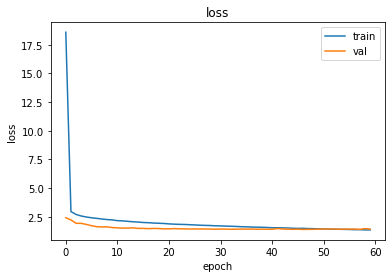

In [28]:
# summarize history for accuracy
plt.plot(tr_loss ) 
plt.plot(val_loss)
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Model evaluation 

In [29]:
test_dataset = dataset(
        test , categorical_features , Numerical_features 
    )
test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=4
    )
val = eval_fn(test_data_loader, model)
print(f" TEST RMSE = {np.sqrt(val)}")


 TEST RMSE = 1.1642294663274764


In [30]:
def plot(region , year , month , day ) : 
    data['year']  = data['Time'].dt.year
    data['month'] = data['Time'].dt.month
    data['days']  = data['Time'].dt.day
    sub_plot = data[(data['REGION_ID']==region)&(data['year']==year)&(data['month']==month)& (data['days']<day)]
    sub_plot = sub_plot.sort_values('Time')
    y=  sub_plot['SPEED'].values
    x_data = dataset(
        sub_plot , categorical_features , Numerical_features 
    ) 
    x_data_loader = torch.utils.data.DataLoader(
        x_data,
        batch_size=VALID_BATCH_SIZE,
        num_workers=4
    )
    predictions  =predict(model,x_data_loader).reshape(1,-1)[0]
    plt.figure(figsize=(24, 8))
    plt.plot(sub_plot['Time'].values , sub_plot['SPEED'].values, '--',label = 'real values')
    plt.plot(sub_plot['Time'].values , predictions,label = 'predicted values')
    plt.ylabel(f'SPEED in region id {region}')
    plt.title(f' predicted vs real values ')
    plt.xlabel('Time')
    plt.grid(True)
    plt.legend()

    plt.show()

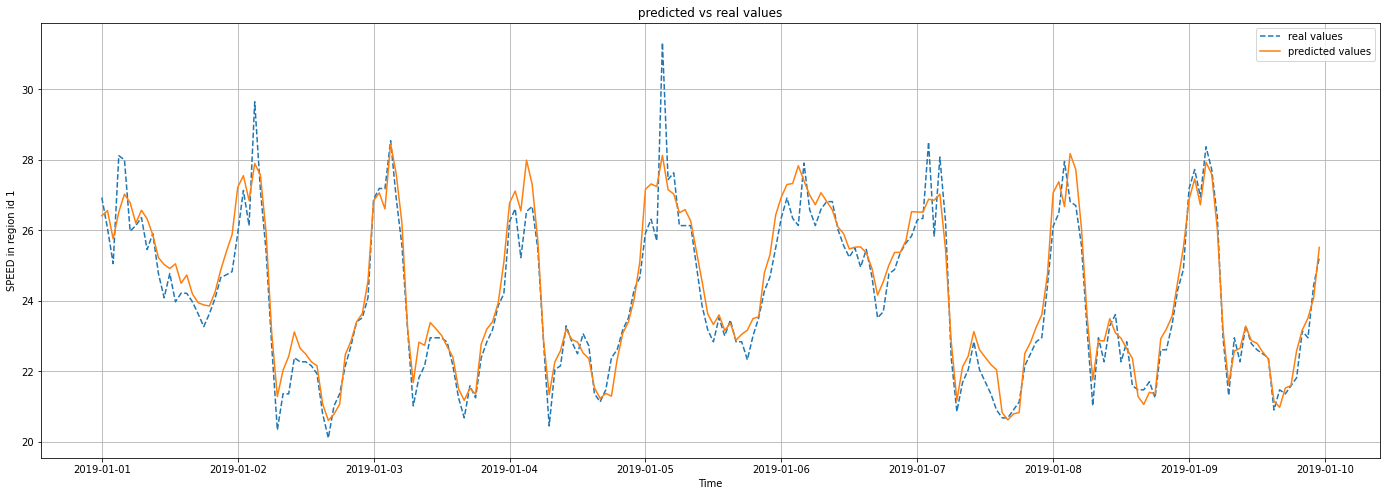

In [31]:
plot(1,2019,1,10)


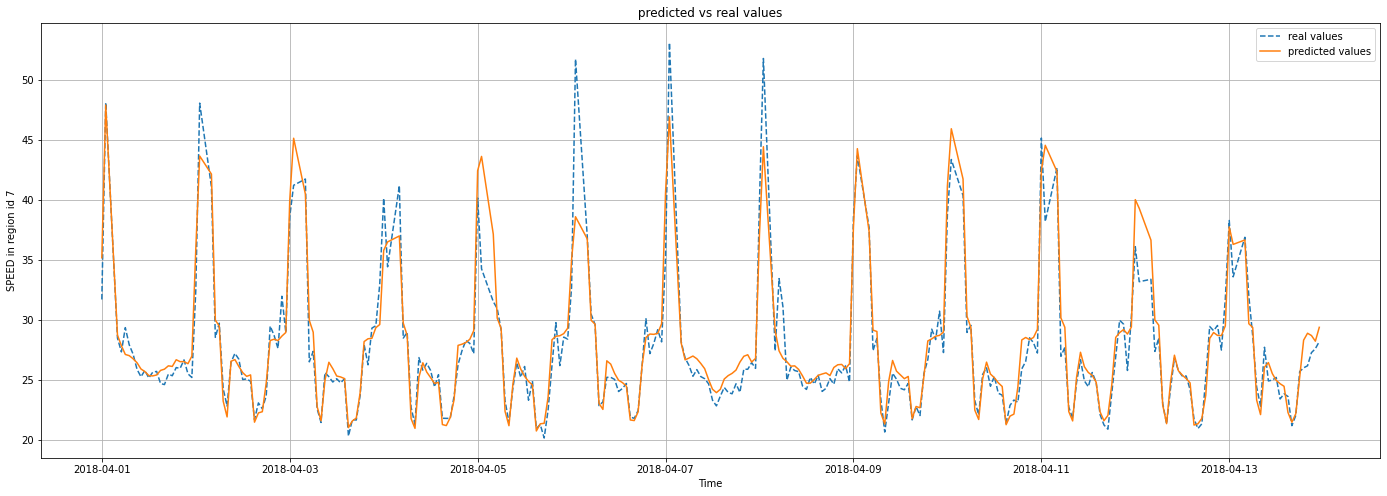

In [32]:
plot(7,2018,4,14)


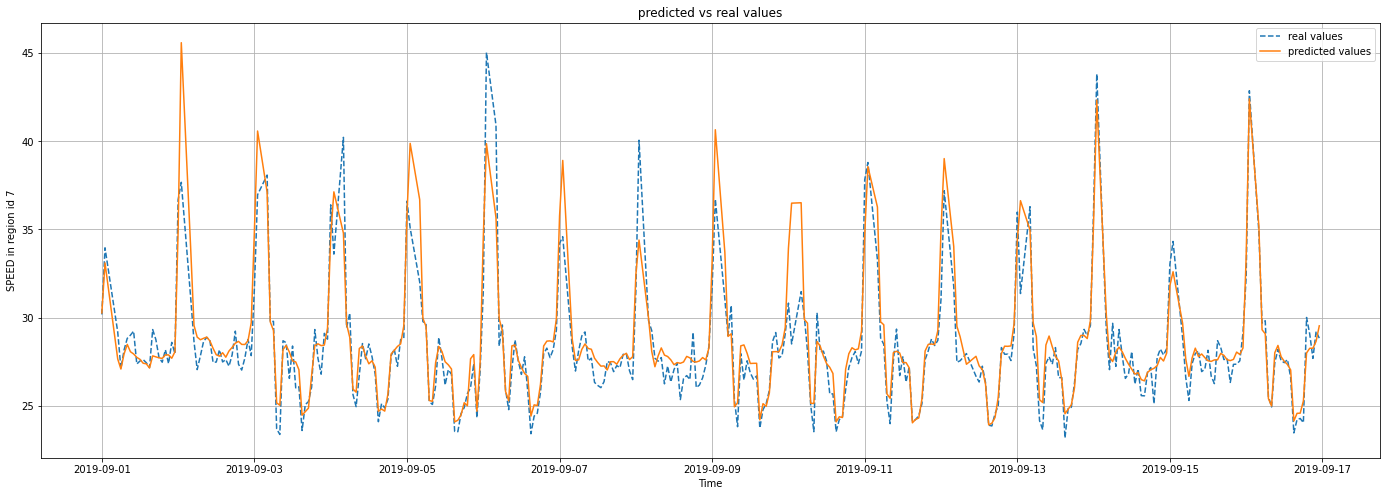

In [33]:
plot(7,2019,9,17)
